# File Autoencoder

### Feature Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from ml_utils import feature_from_dir, translate_bytes
import time

test_set_dir = "/Users/ryan/Documents/CS/CDAC/official_xtract/sampler_dataset/pub8"

raw_features = feature_from_dir(test_set_dir, byte_num=512)
untranslated_features = translate_bytes(raw_features)

x = untranslated_features / 255
x_train, x_test, _, _ = train_test_split(x, x)

print(len(x))

### Model

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping

input_size = len(x_train[0])

input_layer = Input((input_size,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded) 
decoded = Dense(input_size, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size = 256,
                          shuffle=True,
                          callbacks=[EarlyStopping()],
                          validation_data=(x_test, x_test))

encoder = Model(input_layer, encoded)


### Results visualization

In [ ]:
%%capture --no-display 
import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

# File Classifier

### Loading Autoencoder Model

In [1]:
from keras.models import load_model

encoder = load_model("encoder_model.h5")

Using TensorFlow backend.
W1120 10:39:13.917917 4337505728 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1120 10:39:13.931505 4337505728 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1120 10:39:13.976327 4337505728 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1120 10:39:13.977170 4337505728 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is dep

### Feature and Label Grabbing

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from ml_utils import grab_labels, feature_from_file, translate_bytes
import csv

le = LabelEncoder()
naivetruth_path = "/Users/ryan/Documents/CS/CDAC/xtract_autoencoder/automated_training_results/balanced_cdiac_subset.csv"

labels, file_paths = grab_labels(naivetruth_path)
labels.pop(0) #Gets rid of headers
file_paths.pop(0)

x = []

for file_path in file_paths:
    x.append(feature_from_file(file_path))

x = encoder.predict(translate_bytes(x) / 255)
y = to_categorical(le.fit_transform(labels), 6)

x_train, x_test, y_train, y_test = train_test_split(x, y)

print(x_train.shape)

(7894, 64)


In [3]:
print(le.classes_)
for unique in set(labels):
    print("{} is {} and there are {} files".format(unique, ((labels.count(unique) / len(labels)) * 100), labels.count(unique)))

['freetext' 'image' 'json/xml' 'netcdf' 'tabular' 'unknown']
tabular is 25.470264107923235 and there are 2681 files
unknown is 22.81968459053772 and there are 2402 files
netcdf is 2.4320729621888657 and there are 256 files
json/xml is 22.800684020520613 and there are 2400 files
image is 3.6766102983089493 and there are 387 files
freetext is 22.800684020520613 and there are 2400 files


## Deep Classifier Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

classifier_dim = len(x[0])
output_dim = len(y[0])

classifier_model = Sequential()
classifier_model.add(Dense(128, activation='relu', input_shape=(classifier_dim,)))
classifier_model.add(Dense(100, activation='relu'))
classifier_model.add(Dense(64, activation='relu'))
classifier_model.add(Dense(32, activation='relu'))
classifier_model.add(Dense(16, activation='relu'))
classifier_model.add(Dense(8, activation='relu'))
classifier_model.add(Dense(output_dim, activation='softmax'))

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()

history = classifier_model.fit(x_train, y_train,
                               epochs=50,
                               batch_size = 16,
                               shuffle=True,
                               validation_data=(x_test, y_test)) 

In [ ]:
%%capture --no-display 

import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

### Validation Results (Binary Classifier):
 - Trained on cdiac_subset:
     - cdiac_naivetruth: 0.87
     - nist_subset: 0.77
     - cdiac_subset: 0.91
 - Trained on cdiac_naivetruth:
     - cdiac_naivetruth: 0.92
     - nist_subset: 0.82
     - cdiac_subset: 0.94
 - Trained on nist_subset:
     - cdiac_naivetruth: 0.65
     - nist_subset: 0.96
     - cdiac_subset: 0.65 

### Validation Results (Categorical Classifier) (32,28,24,16,8,6 inputs):
 - Trained on cdiac_subset:
     - cdiac_naivetruth: 0.80
     - nist_subset: 0.50
     - cdiac_subset: 0.89
 - Trained on cdiac_naivetruth (adam optimizer):
     - cdiac_naivetruth: 0.91
     - nist_subset: 0.50
     - cdiac_subset: 0.87
 - Trained on nist_subset:
     - cdiac_naivetruth: 0.40
     - nist_subset: 0.93
     - cdiac_subset: 0.43

## Convolutional Model

In [4]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPooling1D, GlobalMaxPooling1D, Reshape, Flatten


classifier_model = Sequential()
classifier_model.add(Reshape((len(x[0]), 1), input_shape=(len(x[0]),)))
classifier_model.add(Conv1D(50, 16, activation='relu'))
classifier_model.add(MaxPooling1D(pool_size=2))
classifier_model.add(Conv1D(50, 16, activation='relu'))
classifier_model.add(GlobalMaxPooling1D())
classifier_model.add(Dense(50, activation='relu'))
classifier_model.add(Dense(32, activation='relu'))
classifier_model.add(Dense(28, activation='relu'))
classifier_model.add(Dense(24, activation='relu'))
classifier_model.add(Dense(16, activation='relu'))
classifier_model.add(Dense(8, activation='relu'))
classifier_model.add(Dense(6, activation='softmax'))

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()

history = classifier_model.fit(x_train, y_train,
                               epochs=50,
                               batch_size = 16,
                               shuffle=True,
                               validation_data=(x_test, y_test)) 

W1120 10:39:18.837872 4337505728 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1120 10:39:18.921439 4337505728 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1120 10:39:18.998682 4337505728 deprecation.py:323] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 49, 50)            850       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 50)             40050     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1632      
__________

7894/7894 [==============================] - 1s 164us/step - loss: 0.0819 - acc: 0.9729 - val_loss: 0.1762 - val_acc: 0.9498
Epoch 47/50
7894/7894 [==============================] - 1s 162us/step - loss: 0.0732 - acc: 0.9719 - val_loss: 0.1810 - val_acc: 0.9498
Epoch 48/50
7894/7894 [==============================] - 1s 145us/step - loss: 0.0738 - acc: 0.9712 - val_loss: 0.1653 - val_acc: 0.9521
Epoch 49/50
7894/7894 [==============================] - 1s 132us/step - loss: 0.0701 - acc: 0.9737 - val_loss: 0.1903 - val_acc: 0.9502
Epoch 50/50
7894/7894 [==============================] - 1s 116us/step - loss: 0.0766 - acc: 0.9716 - val_loss: 0.1768 - val_acc: 0.9468


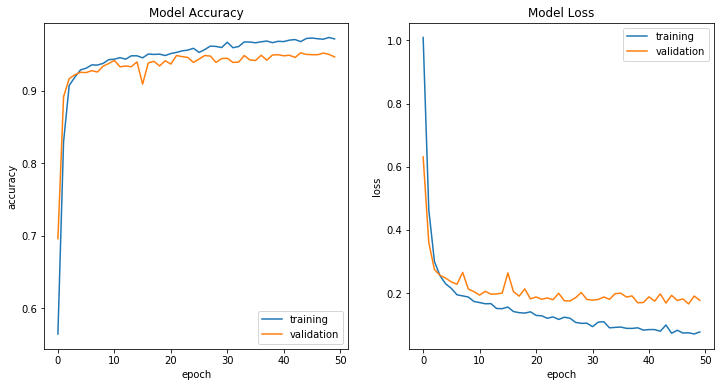

In [5]:
%%capture --no-display 

import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,6))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

## Validation

In [6]:
import csv
from ml_utils import grab_labels, feature_from_file, translate_bytes, features_from_list

validation_set = "/Users/ryan/Documents/CS/CDAC/xtract_autoencoder/automated_training_results/cdiac_naivetruth.csv"

validation_labels, validation_paths = grab_labels(validation_set)
validation_labels.pop(0) #Gets rid of headers
validation_paths.pop(0)

validation_features = features_from_list(validation_paths)

validation_encoded = encoder.predict(translate_bytes(validation_features) / 255, verbose=True)
validation_labels = to_categorical(le.transform(validation_labels), 6)
validation_predictions = classifier_model.predict(validation_encoded, verbose=True)

14343/14343 [==============================] - 0s 21us/step


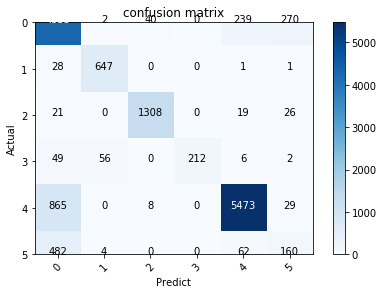

In [7]:
from ml_utils import convert_to_index, plot_confusion_matrix
from pycm import ConfusionMatrix
import numpy as np

# apply conversion function to data
y_test_ind = convert_to_index(validation_labels)
y_pred_test_ind = convert_to_index(validation_predictions)

# compute confusion matrix
cm_test = ConfusionMatrix(y_test_ind, y_pred_test_ind)
np.set_printoptions(precision=2)

# plot confusion matrix result
plt.figure()
plot_confusion_matrix(cm_test,title='confusion matrix')

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

validation_accuracy = accuracy_score(y_test_ind, y_pred_test_ind)
validation_recall = recall_score(y_test_ind, y_pred_test_ind, average='micro')

print(validation_accuracy)

0.8459178693439309
